# CS146 Project 2: Discrete and Multi-Level Models

Here is a data set of kelp plant counts near the coast. The coastal area was divided into 100 20 m × 20 m grid squares and the number of kelp was painstakingly counted in each grid square. Unfortunately, some of the grid squares were not counted.

Your task is to fit an appropriate discrete count model for this data set and to estimate the number of kelp in the missing cells.

Prior knowledge: We expect something like 0 to 2 kelp plants per square meter. Note: Each grid square has an area of 400 m².

## Instructions

1. Complete all the required tasks below. There are also some optional tasks for extra credit.
2. Create a Python notebook with all your code, results, and the interpretation of your results. This Python notebook is your main deliverable for the assignment.
3. Keep it professional! Imagine you are writing your code and text for a client. You will be graded accordingly.

## Data

The integer values below are the recorded kelp counts. There are some `nan` values where we have missing data. The missing data show up as white squares in the plot below.

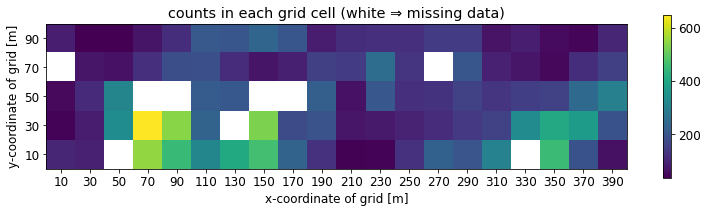

In [177]:
import matplotlib.pyplot as plt
import numpy as np
from numpy import nan
import arviz as az

plt.rcParams.update({'font.size': 12})

grid_count_x = 20  # number of grid cells in the x and y directions
grid_count_y = 5
grid_cell_width = 20  # number of meters per grid cell side
area_per_cell = grid_cell_width ** 2  # each grid cell has an area of (20 m)² = 400 m²

grid_x = (np.arange(grid_count_x) + 0.5) * grid_cell_width
grid_y = (np.arange(grid_count_y) + 0.5) * grid_cell_width

data = np.array([
    [101,  92, nan, 550, 450, 318, 408, 465, 232, 123,  39,  41, 123, 226, 198, 307, nan, 454, 191,  63],
    [ 43,  86, 334, 649, 540, 231, nan, 529, 179, 193,  74,  80,  94, 113, 138, 155, 331, 405, 372, 191],
    [ 51, 110, 314, nan, nan, 215, 205, nan, nan, 221,  67, 203, 120, 125, 158, 129, 149, 156, 245, 304],
    [nan,  74,  66, 119, 184, 186, 115,  71,  89, 151, 145, 255, 127, nan, 199,  92,  74,  49, 116, 153],
    [ 87,  36,  37,  70, 116, 207, 201, 235, 199,  84, 117, 118, 121, 144, 146,  69,  87,  54,  44, 101]])

plt.figure(figsize=(13, 3))
plt.title('counts in each grid cell (white ⇒ missing data)')
plt.xlabel('x-coordinate of grid [m]')
plt.ylabel('y-coordinate of grid [m]')
plt.imshow(data, origin='lower')
plt.xticks(np.arange(data.shape[1]), np.array(grid_x, dtype=int))
plt.yticks(np.arange(data.shape[0]), np.array(grid_y, dtype=int))
plt.colorbar()
plt.show()

## Required tasks

1. Come up with a strategy for estimating the values of the missing cells. How can you use the cell values you have to estimate/predict the values of the cells you don’t have? Describe your strategy to the client.
2. Implement two Poisson models to produce the predictions for the missing cells.
  1. Complete pooling. Assume the counts are generated i.i.d. from a Poisson distribution with an unknown rate parameter. Compute the posterior distribution over the rate parameter and make predictions using this posterior distribution.
  2. Partial pooling. Assume a hierarchical/multi-level model where each grid cell has a Poisson distribution with its own rate parater but the rate parameters come from a common prior with unknown parameters. Choose the prior appropriately. Compute the posterior distribution over all the rate parameters and the parameters of your chosen prior and make predictions using this posterior distribution.
3. Explain or demonstrate how you came up with your prior distributions for the two models.
4. Show the predictions of the values of each missing cell. Explain the differences between the predictions of the complete pooling and partial pooling models. You will find that one model is more confident (has less variance in its predictions) than the other model. Explain which model we should prefer.

# Strategy

The coast was surveyed in 20 x 20m cells, but 9 of the 100 cells did not contain data. As it was such a large area to survey, it is understandable that a few areas were forgotten or collected data was lost. 
Rather than continuing without this data, statistical models can be defined and utilized to fit the kelp counts of these missing cells. This way, the data set is more complete to use for future purposes. 

In estimating the cells that were not counted on the coast, we will use our collected data (91 cells) to make predictions. 
I will use two different models to make predictions: one that makes predictions using summaries of the entire set, assuming known cell measurements are part of the same pool (complete pooling, model 1); and the other that makes predictions where each measurement [i] has different parameters, but still assuming known cell measurements inform our estimations (partial pooling, model 2). 

It makes sense to utilize our known data, as we would expect kelp to grow relatively similar to the kelp around it, as they do not grow independently according within the cell boundaries, but rather in naturally determined patterns. Therefore, we reject the no pooling model and utilize the current data via pooling in the two types of models (complete and partial pooling) to predict nan values using the following 4 steps (defined here, executed below):  

1. Filter the data, remove the nan values, and prep for modeling.
2. Explain how to include our priors and what we know before we model (per say, if we did not have our measurement data). 
3. Define the models, display the prior predictive distribution, sample from each, check the quality of our sampler, display the posterior distribution and the mean of distribution, and finally, model the coastline by filling nan values. 
4. Discuss and evaluate the models. 


## Prepping Data 

In [178]:
# importing the modules to create a new data frame where each data count has its own 3 parameters
import pandas as pd
import pymc as pm 
import scipy.stats as sts
   
# making a data frame to work with  
    
    
# step 1) filtering data, removing nan values and turning into list to then turn into df 
data2 = []
for y in range(0, grid_count_y): 
    for x in range(0, grid_count_x): 
        if np.isnan(data[y][x]) == False: 
            new = [data[y][x]]
            data2.append(new)        
            
# step 2) creating a list of index values for the df , 0-91 for each data count (quadrant of kelp counts)
index_values = []
for x in range(len(data2)):
    index_values.append(x)

# step 3) creating the column value for the new data frame
column_vals = ['kcount']


# step 4) creating data frame 
df = pd.DataFrame(data = data2,
                 index = index_values,
                 columns = column_vals)

df

,kcount
0,101.0
1,92.0
2,550.0
3,450.0
4,318.0
...,...
86,69.0
87,87.0
88,54.0
89,44.0


# Model Implementation 

### Knowns (Prior Knowledge)  

We have prior knowledge that there are between 0 to 2 kelp per square meter. This equates to anywhere between 0 and 800 kelp per cell in our model, with an average of 400 kelp per cell. 

Therefore, we want a parameter to prior over this that factors into our likelihood function -- alpha (used in both models).

## Poisson Model 1 Complete Pooling

In the poisson model, model c is the likelihood of our cells having lam value, or the expected kelp per cell rate. Noted, this is a rate parameter: the amount of kelp we expect to see per cell. From this model, samples are taken to visualize the prior predictive and then use pymc to plot the posterior to make the nan predictions. 

**The CS variable**: As discussed in the knowns section above, the prior knowledge is the rate of 0 to 2 kelps per square meter. This rate can be multiplied by our area, of 400 squares per cell, to estimate the kelp count.

**The prior parameter**: Distributing alpha normally here was done as a convention, centering the mean around 0 and a variance of 0.5, in total with 99.99% of the distribution varying from -2 to 2. 

**The logit function**: The logit function will handle the negative values, prioring the lambda value in our poisson likelihood function (for both models). Log link is used to transform the alpha parameter to remain within positive values; in the normal, alpha ranges from negative infinity to positive infinity. After transformation, it ranges from 0 to positive infinity. 

**The lam parameter (lambda)**: This parameter is our kelp count -- or mean number of kelps to see within a cell. As mentioned, lam is shaped by our priors to be used in the poisson likelihood function. It is deterministic. 

**Likelihood function**: This likelihood function works best for this type of problem. In the poisson distribution, lambda is the mean number of events within an interval of time or space, which is exactly what the kelp measurements are. Lambda can take on any value from 0 to positive infinity, which we assume to be more or less true, though there are natural and quite literal bounds to this assumption (kelp need their space to grow). However, for this problem, (who knows!) many hundred kelp could live in one cell. 

Complete pooling uses one c for all cells. This is not specific to any cell but compiles across all cells to make predictions. This model is the simpler of the two. 


In [179]:
# known Cell Size (Area), used to multiply our rate parameter, lam, by when estimating the kelp count per cell 
CS = 400 

# defining model 1, complete pooling 
with pm.Model() as model_1: 
    
    #Prior 
    a = pm.Normal('a', mu=0, sigma=0.5)
    
    #taking inverse logit 
    logit = pm.math.exp(a)*CS
    #defining lambda value 
    lam = pm.Deterministic('lam', logit)
    
    #likelihood function using our observed kelp count values & prior
    c = pm.Poisson('c', mu=lam, observed=df.kcount.values)
    
    #sample prior predictive 
    samples = pm.sample_prior_predictive(10000)


/Users/graysonmessenger/opt/anaconda3/lib/python3.9/site-packages/pymc/aesaraf.py:1005: UserWarning: The parameter 'updates' of aesara.function() expects an OrderedDict, got <class 'dict'>. Using a standard dictionary here results in non-deterministic behavior. You should use an OrderedDict if you are using Python 2.7 (collections.OrderedDict for older python), or use a list of (shared, update) pairs. Do not just convert your dictionary to this type before the call as the conversion will still be non-deterministic.
  aesara_function = aesara.function(


To visualize what we expect to see from our model without incorporation of data, the prior predictive is used. 

Here, it looks reasonable, left skewed as per the lack of upper bound to our kelp count per cell. 

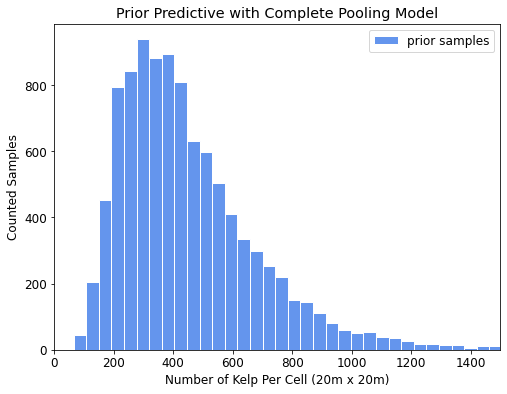

In [180]:
# plotting the prior predictive to examine the behavior of our complete pooling model 

plt.figure(figsize=(8, 6))
plt.title('Prior Predictive with Complete Pooling Model')
plt.hist(samples.prior.lam.values.flat, color='cornflowerblue', bins=70, edgecolor='white', label='prior samples')
plt.xlim((0, 1500))
plt.xlabel('Number of Kelp Per Cell (20m x 20m)')
plt.ylabel('Counted Samples')
plt.legend()
plt.show()

Now, sampling is completed and the sampler is analyzed using rank plots and summary statistics. 

In [181]:
# taking samples from our complete pooling model to predict the nan kelp count cells on the coast 
with model_1: 
    inference1_all = pm.sample() 

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a]


/Users/graysonmessenger/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/graysonmessenger/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/graysonmessenger/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/graysonmessenger/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 42 seconds.
The acceptance probability does not match the target. It is 0.8883, but should be close to 0.8. Try to increase the number of tuning ste

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,-0.795,0.008,-0.810,-0.781,0.000,0.000,1538.0,2308.0,1.0
lam,180.577,1.386,177.981,183.128,0.035,0.025,1538.0,2308.0,1.0


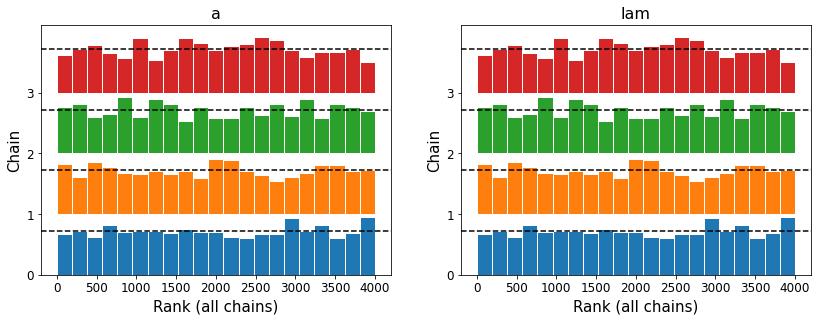

In [182]:
# checking the quality of our sampler, evaluating r_hat and ess values 
az.plot_rank(inference1_all, var_names=['a', 'lam'])
az.summary(inference1_all, var_names=['a', 'lam'])

### Sampler Discussion 

After running rank plots and summary stats, it looks like the sampler is working correctly. 

**Rank plots**: Using 4 chains, they all look relatively uniform, following the dotted line. The r_hat values reflect this, with both a and lam parameters at 1.0. 

**The summary**: High ESS values are displayed, signifying a high effective sample size for both parameters. Our sampler is moving correctly within the distribution and capturing it accurately, as both ESS bulk and ESS tail values are in the 1000s and 2000s.

It does not look like tuning is necessary. 


### Posterior Distribution 

Confirmed that our sampler is working well, we can plot the posterior samples in a histogram to visualize the distribution of lambda values. 


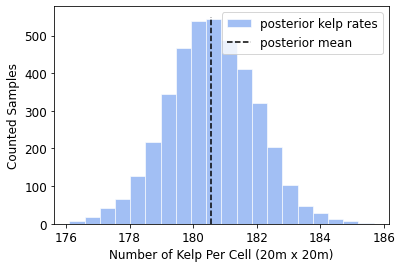

In [183]:
# plotting the posterior distribution of the complete pooling model 
posterior_samples = inference1_all.posterior.lam.values.flatten()

plt.hist(posterior_samples, color='cornflowerblue', alpha=0.6, bins=20, edgecolor='white', label='posterior kelp rates')

# plotting mean, using to fill in nan values 
plt.vlines(np.mean(posterior_samples), 0, 550, color='k', linestyles='dashed', label='posterior mean')

plt.legend()
plt.xlabel('Number of Kelp Per Cell (20m x 20m)')
plt.ylabel('Counted Samples')
plt.show()

The posterior looks relatively normal.

This makes sense, as complete pooling restrains variation by using the same slope and intercept parameters for the likelihood function -- assuming all cell measurements are in the same "pool". 

It should also be noted that the mean of the complete pooling posterior, looks to be approaching the true mean of the training data, or our known cell count values: 

In [184]:
# observing the mean of the data set, the df that we defined earlier without nan values 
print('Mean of data frame:', np.round(np.mean(df.kcount.values), 3))

# compare to the mean of the posterior sample distribution
print('Mean of posterior distribution:', np.round(np.mean(posterior_samples), 3))

Mean of data frame: 180.527
Mean of posterior distribution: 180.577


Using the mean of the posterior distribution as a nan replacement value, it is plotted below beneath the original coastline plot for comparison. 

It looks to blend quite well.

However, there are limitations to this model type due to its lack in variation and "clumping" of all data together, assuming one model is good for all cells on the coast. 

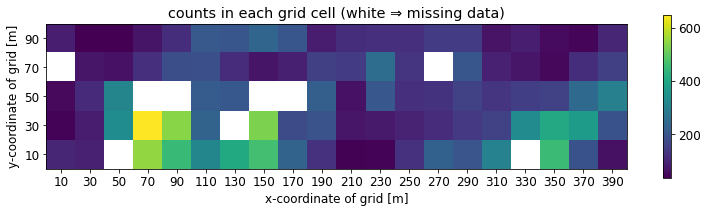

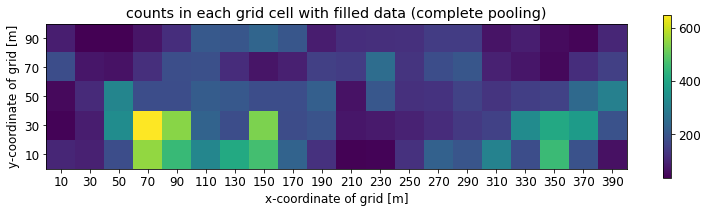

In [185]:
# comparing the two coastal models 

# plotting original with nan values
plt.figure(figsize=(13, 3))
plt.title('counts in each grid cell (white ⇒ missing data)')
plt.xlabel('x-coordinate of grid [m]')
plt.ylabel('y-coordinate of grid [m]')
plt.imshow(data, origin='lower')
plt.xticks(np.arange(data.shape[1]), np.array(grid_x, dtype=int))
plt.yticks(np.arange(data.shape[0]), np.array(grid_y, dtype=int))
plt.colorbar()
plt.show()

# replacing nan values with the mean of our posterior distribution 
data3 = data
data3[np.isnan(data3)] = np.mean(posterior_samples)

# plotting the new coastal model with filled nan values
plt.figure(figsize=(13, 3))
plt.title('counts in each grid cell with filled data (complete pooling)') #
plt.xlabel('x-coordinate of grid [m]')
plt.ylabel('y-coordinate of grid [m]')
plt.imshow(data, origin='lower')
plt.xticks(np.arange(data.shape[1]), np.array(grid_x, dtype=int))
plt.yticks(np.arange(data.shape[0]), np.array(grid_y, dtype=int))
plt.colorbar()
plt.show()


## Poisson Model 2 Partial Pooling

Defining the second model will be very similar to the first, excluding the use of cells and hyperparameters. 

Again, model c is the likelihood of our cells having lam value, or the expected kelp per cell rate. From this model, samples are taken to visualize the prior predictive and then use pymc to plot the posterior to make the nan predictions. 

**The n variable**: This variable is the number of cells we have, to use as [i] in n cell values to estimate hyperparameters. The n variable is present in the alpha prior for this reason, to differentiate between cells' individual parameters.  

**The a_bar parameter**: This is a prior for the mean cell kelp rate per square meter. The mu is still centered around 0, as we know that alpha is going to be transformed via the log link function. There is no inclination to move this value forwards in the positive direction either, per the information we know. 

**The sigma parameter**: This parameter is small, at 0.05 as to leave room for small variation of the mean, if it needs to sway per [i] cell measurement. 

**Likelihood function**: The likelihood function is identical to Model 1 besides the differentiation of mean and slope parameters per [i] individual cell alpha value, priored by a_bar and sigma. The poisson distribution makes sense for the problem -- but this time with the addition of specified lambda parameters for each cell. 

Partial pooling uses a different c_i for all measurements. Though each cell has individual prior parameters, allowing for greater variation across groups, data from all observed cells still informs estimates for nan values. This model is a bit more complex than complete pooling. 

In [186]:
# defining our number of cells, used to partially pool with independent parameters per i "cell" value. 
n = 91 

with pm.Model() as model_2: 
    
    #Hyperparameters 
        #Remember: here, we are considering the rate of a, which is the rate per square m, originally 
          
    a_bar = pm.Normal('a_bar', mu=0, sigma=0.05) 
    sigma = pm.Uniform('sigma', lower=0.4, upper=0.6) #prior for standard deviation of kelp rates 
    
    #Adaptive Prior (+ log link function)
    a = pm.Normal('a', shape=n, mu=a_bar, sigma=sigma)
    
    #taking inverse logit 
    logit = pm.math.exp(a)*CS
    #defining lambda value 
    lam = pm.Deterministic('lam', logit)
    
    #likelihood function using our observed kelp count values 
    c = pm.Poisson('c', mu=lam, observed=df.kcount.values)
    
    #sampling prior predictive 
    samples2 = pm.sample_prior_predictive(10000)


/Users/graysonmessenger/opt/anaconda3/lib/python3.9/site-packages/pymc/aesaraf.py:1005: UserWarning: The parameter 'updates' of aesara.function() expects an OrderedDict, got <class 'dict'>. Using a standard dictionary here results in non-deterministic behavior. You should use an OrderedDict if you are using Python 2.7 (collections.OrderedDict for older python), or use a list of (shared, update) pairs. Do not just convert your dictionary to this type before the call as the conversion will still be non-deterministic.
  aesara_function = aesara.function(


To visualize what we expect to see from our model without incorporation of data, the prior predictive is used. 

Similar to the first model, it looks reasonable, left skewed as per the lack of upper bound to our kelp count per cell. 

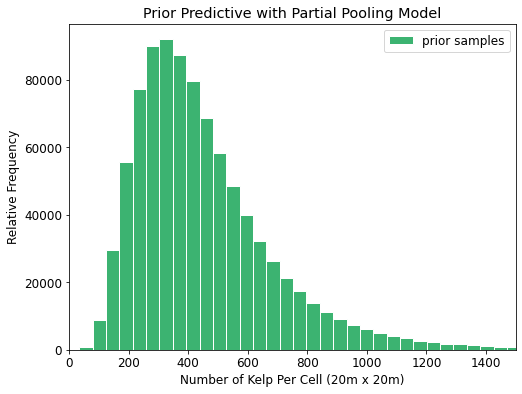

In [187]:
# plotting the prior predictive to examine the behavior of our partial pooling model 

plt.figure(figsize=(8, 6))
plt.title('Prior Predictive with Partial Pooling Model')
plt.hist(samples2.prior.lam.values.flat, bins=110, color='mediumseagreen', edgecolor='white', label='prior samples')
plt.xlim((0, 1500))
plt.legend()
plt.xlabel('Number of Kelp Per Cell (20m x 20m)')
plt.ylabel('Relative Frequency')
plt.show()

Now, sampling is completed and the sampler is analyzed using rank plots and summary statistics. 

In [188]:
# taking samples from our distribution to predict the nan kelp count cells on the coast 
with model_2: 
    inference2_all = pm.sample(tune=3000) 

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a_bar, sigma, a]


Sampling 4 chains for 3_000 tune and 1_000 draw iterations (12_000 + 4_000 draws total) took 39 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a_bar,-0.394,0.040,-0.464,-0.315,0.000,0.000,7381.0,2827.0,1.0
a[0],-1.354,0.096,-1.535,-1.181,0.001,0.001,9540.0,2567.0,1.0
a[1],-1.443,0.102,-1.627,-1.240,0.001,0.001,9116.0,2586.0,1.0
a[2],0.314,0.042,0.232,0.391,0.000,0.000,8103.0,2475.0,1.0
a[3],0.114,0.048,0.028,0.207,0.001,0.000,8007.0,2561.0,1.0
...,...,...,...,...,...,...,...,...,...
lam[86],72.796,8.364,57.675,88.648,0.086,0.068,10569.0,2261.0,1.0
lam[87],90.110,9.359,73.478,108.040,0.097,0.072,9484.0,2783.0,1.0
lam[88],58.302,7.497,44.502,72.415,0.077,0.056,9431.0,2663.0,1.0
lam[89],48.781,6.713,37.010,61.810,0.076,0.056,7854.0,2516.0,1.0


/Users/graysonmessenger/opt/anaconda3/lib/python3.9/site-packages/arviz/plots/plot_utils.py:271: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of variables to plot (184) in plot_rank, generating only 40 plots
  warnings.warn(


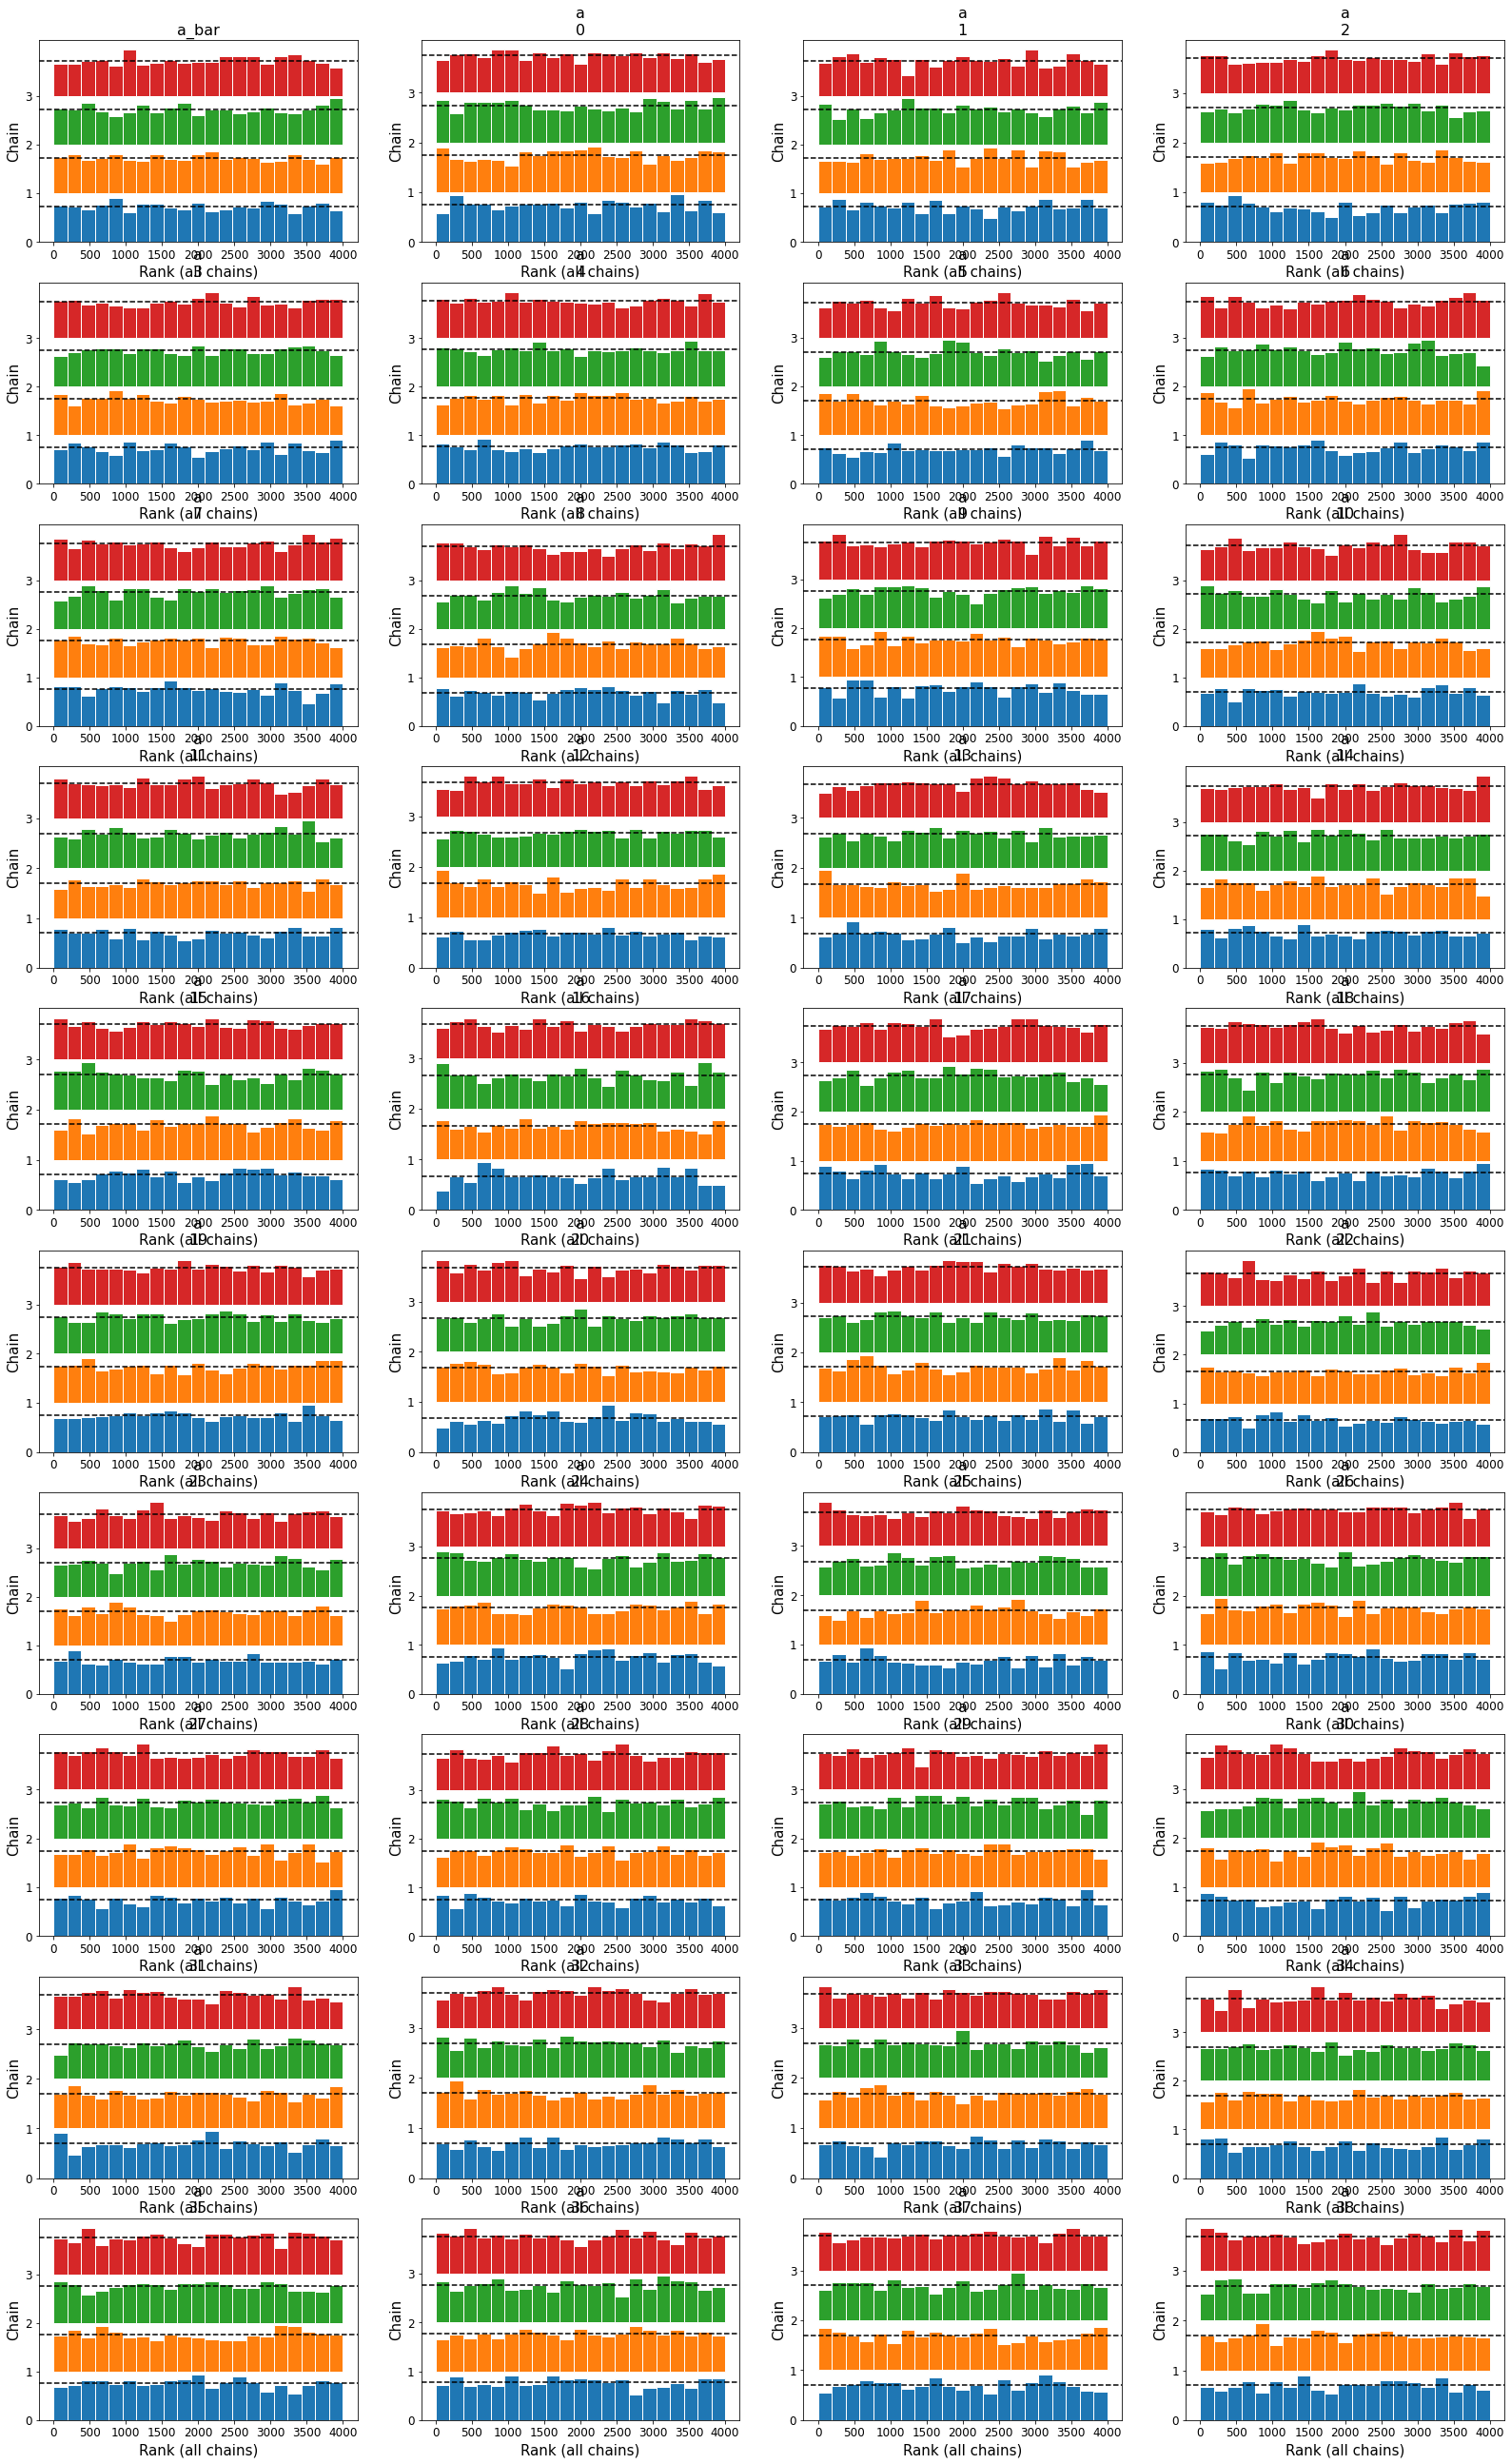

In [189]:
# checking the quality of our sampler, evaluating r_hat and ess values (per i data point, or known cell value)
display(az.summary(inference2_all)) 
az.plot_rank(inference2_all) 
plt.show()

### Sampler Discussion 

After running rank plots and summary stats, it looks like the sampler is working correctly. 

As we are using different parameters for each instance, [i], we will have rank plots for each alpha-lambda pair per measurement. It is important that all of the plots look uniform, as to not inaccurately depict one (or a few) of the measurements -- this could possibly skew the results.  

**Rank plots**: Using 4 chains, all look relatively uniform. The r_hat values reflect this, with a and lam parameters at 1.0. 

**The summary**: High ESS values are displayed, signifying a high effective sample size for both parameters. Our sampler is moving correctly within the distribution and capturing it accurately, as both ESS bulk and ESS tail values are in the 2000s to 9000s.

It does not look like tuning is necessary. 


### Posterior Distribution 

Confirmed that our sampler is working well, we can plot the posterior samples in a histogram to visualize the distribution of lambda values. 


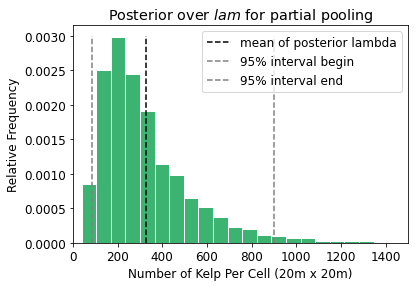

In [190]:
# plotting the posterior distribution of the partial pooling model 

# flattening values from all of our hyperparameters, to feed alpha, to then enter the log link function & lam 
post_a_bar = inference2_all.posterior.a_bar.values.flatten() 
post_sigma = inference2_all.posterior.sigma.values.flatten()
post_a = sts.norm.rvs(loc=post_a_bar, scale=post_sigma) # use all the values fro post_lam_partial = special_link(post_a_partial, 0.65) # deterministically get values for

# log link function, adjusted. Appending lam values to plot on histogram. 
post_lam = []
for val in post_a: 
    post_lam.append(np.exp(val)*CS)

plt.title('Posterior over $lam$ for partial pooling') 
plt.vlines(np.mean(post_lam), 0, 0.003, color='k', linestyles='dashed', label='mean of posterior lambda')

# plotting lines for confidence inetervals 
plt.vlines(np.percentile(post_lam, 2.5), 0, 0.003, color='gray', linestyles='dashed', label='95% interval begin')
plt.vlines(np.percentile(post_lam, 97.5), 0, 0.003, color='gray', linestyles='dashed', label='95% interval end')

plt.hist(post_lam, color='mediumseagreen', bins=40 , edgecolor='white', density=True)
plt.legend()
plt.xlim((0, 1500))
plt.xlabel('Number of Kelp Per Cell (20m x 20m)')
plt.ylabel('Relative Frequency')
plt.show()


The posterior is left skewed.

This makes sense, as the cells were allowed to maintain the variation within the bounds of the poisson distribution, to positive infinity. Of course, this was done within the alpha parameter backed by hyperparameters -- which keep the majority of the posterior within the 0-800 kelp range, as predicted. 

Additionally, I plotted a 95% confidence interval. A mean can be pinned on this plot, but it would not represent any variation that this posterior distribution displays. This is true, as the single summary statistic does not represent other qualities of the distribution. 

Therefore, I will present the lower and upper margins for this interval, alongside the summary statistic: 

In [191]:
# observing the mean of the data set, the df that we defined earlier without nan values 
print('Mean of data frame:', np.round(np.mean(df.kcount.values), 3))

# compare to the mean of the posterior sample distribution
print('Mean of posterior distribution:', np.round(np.mean(post_lam), 3))


# printing confidence interval values 
print('Lower Margin:', np.round(np.percentile(post_lam, 2.5), 3))
print('Upper Margin:', np.round(np.percentile(post_lam, 97.5), 3))

Mean of data frame: 180.527
Mean of posterior distribution: 324.879
Lower Margin: 82.642
Upper Margin: 899.858


The range of values that can fill the nan values is quite large. 

Notably, the mean of this model's posterior distribution is roughly 100 kelps larger than the first model's. This is possibly due to the increased variation that the hyperparameters give the prior in "limiting" the pooled predictions. 

For visual comparison, I plotted the mean value for the lambdas, simply as a visual comparison to the first model.

It also looks well-blended. The nan values appear to be on the high side, with lighter colors compared to their neighbors, but again, the single-summary-statistic is not the best measurement of the accuracy of Model 2. This coloration seems plausible. 

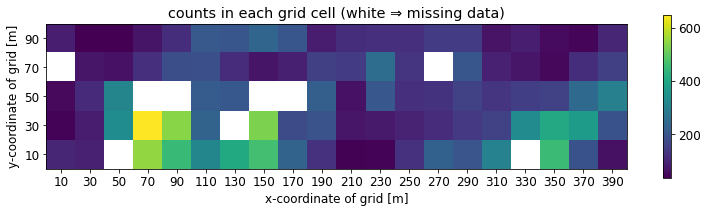

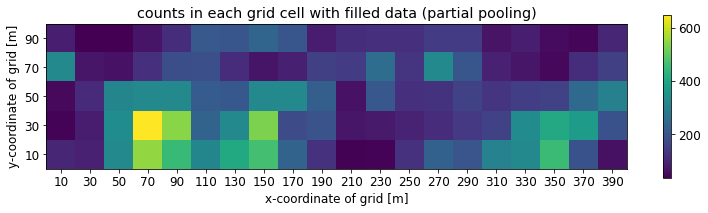

In [192]:
# comparing the two coastal models 

# plotting original with nan values

# rerunning original array & plot 
data = np.array([
    [101,  92, nan, 550, 450, 318, 408, 465, 232, 123,  39,  41, 123, 226, 198, 307, nan, 454, 191,  63],
    [ 43,  86, 334, 649, 540, 231, nan, 529, 179, 193,  74,  80,  94, 113, 138, 155, 331, 405, 372, 191],
    [ 51, 110, 314, nan, nan, 215, 205, nan, nan, 221,  67, 203, 120, 125, 158, 129, 149, 156, 245, 304],
    [nan,  74,  66, 119, 184, 186, 115,  71,  89, 151, 145, 255, 127, nan, 199,  92,  74,  49, 116, 153],
    [ 87,  36,  37,  70, 116, 207, 201, 235, 199,  84, 117, 118, 121, 144, 146,  69,  87,  54,  44, 101]])

plt.figure(figsize=(13, 3))
plt.title('counts in each grid cell (white ⇒ missing data)')
plt.xlabel('x-coordinate of grid [m]')
plt.ylabel('y-coordinate of grid [m]')
plt.imshow(data, origin='lower')
plt.xticks(np.arange(data.shape[1]), np.array(grid_x, dtype=int))
plt.yticks(np.arange(data.shape[0]), np.array(grid_y, dtype=int))
plt.colorbar()
plt.show()

# replacing nan values with the mean of our posterior distribution 
data4 = data
data4[np.isnan(data4)] = np.mean(post_lam)

# plotting the new coastal model with filled nan values
plt.figure(figsize=(13, 3))
plt.title('counts in each grid cell with filled data (partial pooling)') 
plt.xlabel('x-coordinate of grid [m]')
plt.ylabel('y-coordinate of grid [m]')
plt.imshow(data, origin='lower')
plt.xticks(np.arange(data.shape[1]), np.array(grid_x, dtype=int))
plt.yticks(np.arange(data.shape[0]), np.array(grid_y, dtype=int))
plt.colorbar()
plt.show()


# Model Visuals

Below, the three different coastal maps. 

1. Original, with white nan values. 
2. Model 1, complete pooling. 
3. Model 2, partial pooling. 

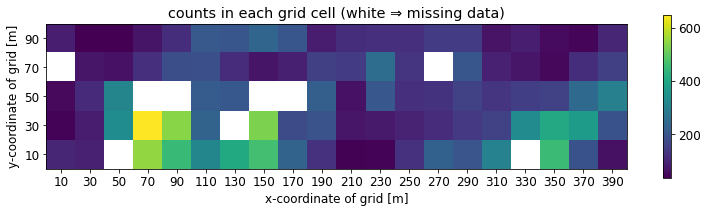

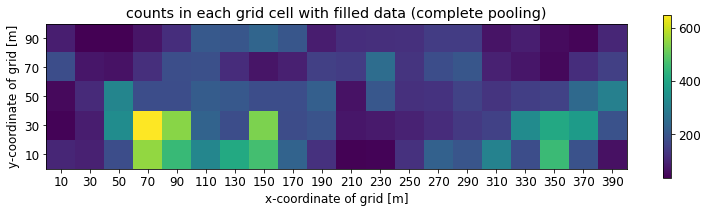

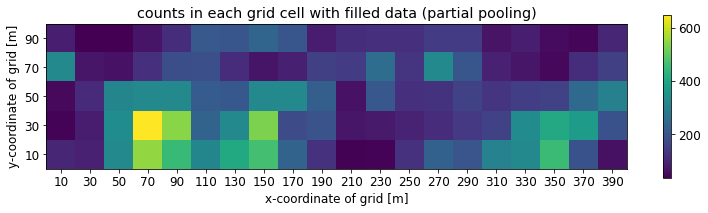

In [193]:
# rerunning original array & plot 
data = np.array([
    [101,  92, nan, 550, 450, 318, 408, 465, 232, 123,  39,  41, 123, 226, 198, 307, nan, 454, 191,  63],
    [ 43,  86, 334, 649, 540, 231, nan, 529, 179, 193,  74,  80,  94, 113, 138, 155, 331, 405, 372, 191],
    [ 51, 110, 314, nan, nan, 215, 205, nan, nan, 221,  67, 203, 120, 125, 158, 129, 149, 156, 245, 304],
    [nan,  74,  66, 119, 184, 186, 115,  71,  89, 151, 145, 255, 127, nan, 199,  92,  74,  49, 116, 153],
    [ 87,  36,  37,  70, 116, 207, 201, 235, 199,  84, 117, 118, 121, 144, 146,  69,  87,  54,  44, 101]])

# plotting original with nan values
plt.figure(figsize=(13, 3))
plt.title('counts in each grid cell (white ⇒ missing data)')
plt.xlabel('x-coordinate of grid [m]')
plt.ylabel('y-coordinate of grid [m]')
plt.imshow(data, origin='lower')
plt.xticks(np.arange(data.shape[1]), np.array(grid_x, dtype=int))
plt.yticks(np.arange(data.shape[0]), np.array(grid_y, dtype=int))
plt.colorbar()
plt.show()

# replacing nan values with the mean of our posterior distribution 
data3 = data
data3[np.isnan(data3)] = np.mean(posterior_samples)

# plotting the new coastal model with filled nan values
plt.figure(figsize=(13, 3))
plt.title('counts in each grid cell with filled data (complete pooling)') #
plt.xlabel('x-coordinate of grid [m]')
plt.ylabel('y-coordinate of grid [m]')
plt.imshow(data, origin='lower')
plt.xticks(np.arange(data.shape[1]), np.array(grid_x, dtype=int))
plt.yticks(np.arange(data.shape[0]), np.array(grid_y, dtype=int))
plt.colorbar()
plt.show()

# rerunning original array & plot 
data = np.array([
    [101,  92, nan, 550, 450, 318, 408, 465, 232, 123,  39,  41, 123, 226, 198, 307, nan, 454, 191,  63],
    [ 43,  86, 334, 649, 540, 231, nan, 529, 179, 193,  74,  80,  94, 113, 138, 155, 331, 405, 372, 191],
    [ 51, 110, 314, nan, nan, 215, 205, nan, nan, 221,  67, 203, 120, 125, 158, 129, 149, 156, 245, 304],
    [nan,  74,  66, 119, 184, 186, 115,  71,  89, 151, 145, 255, 127, nan, 199,  92,  74,  49, 116, 153],
    [ 87,  36,  37,  70, 116, 207, 201, 235, 199,  84, 117, 118, 121, 144, 146,  69,  87,  54,  44, 101]])

# replacing nan values with the mean of our posterior distribution 
data4 = data
data4[np.isnan(data4)] = np.mean(post_lam)

# plotting the new coastal model with filled nan values
plt.figure(figsize=(13, 3))
plt.title('counts in each grid cell with filled data (partial pooling)') 
plt.xlabel('x-coordinate of grid [m]')
plt.ylabel('y-coordinate of grid [m]')
plt.imshow(data, origin='lower')
plt.xticks(np.arange(data.shape[1]), np.array(grid_x, dtype=int))
plt.yticks(np.arange(data.shape[0]), np.array(grid_y, dtype=int))
plt.colorbar()
plt.show()

# Model Discussion 

Both the complete pooling and partial pooling models worked to fill the 9 nan places on the coastal kelp map.

However, there are two key differences between the two: 

1. Average Values (the nan fill values). The average value for complete pooling is very near the mean of the dataset, using the existing coastline as a collective to choose a nan value. This lies at about 180, which does not change after many runs of the model. However, the average value for partial pooling changes quite a bit when ran multiple times. Generally, it is larger than the complete pooling average. This is due to the large variance that the partial pooling model has. 


2. Variance. Complete pooling lacks variance, as the same parameters are used for the likelihood function for all cells in the model, treating all cells as the same pool. However, the partial pooling model uses different parameters for each cell [i]. Difference in variation is the cause of different distribution shapes for the posterior. The specialization in partial pooling maintains variance in the kelp rates, with a posterior that ranges a bit outside of the expected 0-800 kelp per 400 square meters. Using a range of values rather than an average value allows the partial pooling model to have greater breadth and applicability, while the complete pooling model is specified to its exact dataset in making nan predictions. 


In choosing a better model, it makes sense to choose the partial pooling model. 

This is because partial pooling better grasps the variation in kelp rates on the coast, the concept that cells are different but not unrelated to one another. This aligns with the scenario, that cells will likely relate to one another in trends with smaller groups, e.g. a dense kelp patch, but also remain anchored in large-scale trends, e.g. the health trends of a kelp population. 
